## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


The cell below contain the library imports needed to read the CSV data files for The Numbers and Rotten Tomatoes.

In [100]:
# Your code here - remember to use markdown cells for comments as well!
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [101]:
# Testing to see if we can bring and API in to supplement our data
import requests
import json
url = 'https://api.themoviedb.org/3/movie/{movie_id}?api_key=<<503f12af247746f5fc6113f4fed1f3a3>>&language=en-US'
TMDB = requests.get(url)

In [102]:
type(TMDB)

requests.models.Response

In [103]:
# Attemp to access an API
TMDB.status_code

401

In [104]:
TMDB_data = TMDB.json()

In [105]:
#Unzipping the SQL
from zipfile import ZipFile
# specifying the zip file name
file_name = "./zippedData/im.db.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
im.db                                          2021-12-20 16:31:38    169443328
Extracting all the files now...
Done!


In [106]:
#Establish the SQL connection
conn = sqlite3.connect('im.db')

In [107]:
# FILES WE WILL USE FOR OUR ANALYSIS
TN_DF = pd.read_csv("./zippedData/tn.movie_budgets.csv.gz")
ROT_TOM_INFO_DF = pd.read_csv("./zippedData/rt.movie_info.tsv.gz", sep="\t")
    
# FILES THAT WE ARE NOT GOING TO USE IN OUR ANALYSIS
ROT_TOM_REV_DF = pd.read_csv("./zippedData/rt.reviews.tsv.gz", sep="\t", encoding='windows-1252')
TMDB_DF = pd.read_csv("./zippedData/tmdb.movies.csv.gz")
BOM_DF = pd.read_csv("./zippedData/bom.movie_gross.csv.gz")

These are the tables that have the information we are going to combine.

In [108]:
cur = conn.cursor()

In [109]:
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
# Fetch the result and store it in table_names
table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [110]:
IMDB_ratings = pd.DataFrame(
    data=cur.execute("""SELECT * FROM movie_ratings;""").fetchall(),
    columns=[x[0] for x in cur.description]
)
IMDB_ratings.shape

(73856, 3)

In [111]:
#This sets the var sql = to the data frame
IMDB = pd.DataFrame(
    data=cur.execute("""SELECT * FROM movie_basics;""").fetchall(),
    columns=[x[0] for x in cur.description]
)

In [112]:
IMDB['start_year'].min()

2010

In [113]:
IMDB_clean = IMDB.copy()

In [114]:
IMDB_clean = IMDB_clean[IMDB['start_year'] >= 2010]

In [115]:
IMDB_clean.shape

(146144, 6)

In [116]:
#I Looked it uo the world wide numbers are actually the total numbers so Im renaming that colomn
TN_DF

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


Below we are cleaning the data by removing the ID column and also the $ sign and commas from the box office numbers. We also are converting the box offices numbers to int in order to make a new column to represent net income.

In [117]:
TN_clean = TN_DF.copy()

In [118]:
TN_clean.drop('id', axis=1, inplace=True)

In [119]:
TN_clean

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...
5777,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [120]:
# Stripping $

TN_clean['production_budget'] = TN_clean['production_budget'].map(lambda x: x.strip('$,'))
TN_clean['domestic_gross'] = TN_clean['domestic_gross'].map(lambda x: x.strip('$,'))
TN_clean['worldwide_gross'] = TN_clean['worldwide_gross'].map(lambda x: x.strip('$,'))

In [121]:
TN_clean

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"425,000,000","760,507,625","2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"410,600,000","241,063,875","1,045,663,875"
2,"Jun 7, 2019",Dark Phoenix,"350,000,000","42,762,350","149,762,350"
3,"May 1, 2015",Avengers: Age of Ultron,"330,600,000","459,005,868","1,403,013,963"
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"317,000,000","620,181,382","1,316,721,747"
...,...,...,...,...,...
5777,"Dec 31, 2018",Red 11,"7,000",0,0
5778,"Apr 2, 1999",Following,"6,000","48,482","240,495"
5779,"Jul 13, 2005",Return to the Land of Wonders,"5,000","1,338","1,338"
5780,"Sep 29, 2015",A Plague So Pleasant,"1,400",0,0


In [122]:
TN_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 226.0+ KB


In [123]:
# stripping ',''

TN_clean = TN_clean.apply(lambda x: x.str.replace(',', ''))

In [124]:
TN_clean

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Dec 18 2009,Avatar,425000000,760507625,2776345279
1,May 20 2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,Jun 7 2019,Dark Phoenix,350000000,42762350,149762350
3,May 1 2015,Avengers: Age of Ultron,330600000,459005868,1403013963
4,Dec 15 2017,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...
5777,Dec 31 2018,Red 11,7000,0,0
5778,Apr 2 1999,Following,6000,48482,240495
5779,Jul 13 2005,Return to the Land of Wonders,5000,1338,1338
5780,Sep 29 2015,A Plague So Pleasant,1400,0,0


In [125]:
TN_clean[['production_budget', 'domestic_gross', 'worldwide_gross']] = TN_clean[['production_budget', 'domestic_gross', 'worldwide_gross']].apply(pd.to_numeric)

In [126]:
TN_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   int64 
 3   domestic_gross     5782 non-null   int64 
 4   worldwide_gross    5782 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 226.0+ KB


We are adding in profitability metrics to the TN_clean data set, including: 1) Net Income 2) Net Income Ratio and 3) ROI.

In [127]:
TN_clean['Net Income'] = TN_clean['worldwide_gross'] - TN_clean['production_budget']

In [128]:
TN_clean['Net_Income_Ratio'] = TN_clean['Net Income'] / TN_clean['worldwide_gross']

In [129]:
TN_clean['ROI'] = TN_clean['Net Income'] / TN_clean['production_budget']

In [130]:
TN_clean

,release_date,movie,production_budget,domestic_gross,worldwide_gross,Net Income,Net_Income_Ratio,ROI
0,Dec 18 2009,Avatar,425000000,760507625,2776345279,2351345279,0.846921,5.532577
1,May 20 2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,0.607331,1.546673
2,Jun 7 2019,Dark Phoenix,350000000,42762350,149762350,-200237650,-1.337036,-0.572108
3,May 1 2015,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,0.764364,3.243841
4,Dec 15 2017,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,0.759251,3.153696
...,...,...,...,...,...,...,...,...
5777,Dec 31 2018,Red 11,7000,0,0,-7000,-inf,-1.000000
5778,Apr 2 1999,Following,6000,48482,240495,234495,0.975051,39.082500
5779,Jul 13 2005,Return to the Land of Wonders,5000,1338,1338,-3662,-2.736921,-0.732400
5780,Sep 29 2015,A Plague So Pleasant,1400,0,0,-1400,-inf,-1.000000


In [131]:
TN_clean['release_date'] = pd.to_datetime(TN_clean['release_date'])

In [132]:
TN_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   int64         
 3   domestic_gross     5782 non-null   int64         
 4   worldwide_gross    5782 non-null   int64         
 5   Net Income         5782 non-null   int64         
 6   Net_Income_Ratio   5782 non-null   float64       
 7   ROI                5782 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 361.5+ KB


In [133]:
TN_clean.sort_values(by=['Net Income'], ascending=False)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,Net Income,Net_Income_Ratio,ROI
0,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,0.846921,5.532577
42,1997-12-19,Titanic,200000000,659363944,2208208395,2008208395,0.909429,10.041042
6,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,0.853525,5.827114
5,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220,0.850972,5.710167
33,2015-06-12,Jurassic World,215000000,652270625,1648854864,1433854864,0.869606,6.669092
...,...,...,...,...,...,...,...,...
352,2001-04-27,Town & Country,105000000,6712451,10364769,-94635231,-9.130472,-0.901288
341,2019-06-14,Men in Black: International,110000000,3100000,3100000,-106900000,-34.483871,-0.971818
193,2011-03-11,Mars Needs Moms,150000000,21392758,39549758,-110450242,-2.792691,-0.736335
194,2020-12-31,Moonfall,150000000,0,0,-150000000,-inf,-1.000000


Next, we are cleaning the IMDB table to remove "N/A" or "Null" values from the "genres", "runtime_minutes", and "original_title" field. We then sorted all movies by "runtime_minutes" (highest to lowest) and removed duplicates where the movie name and year were the same.

In [134]:
IMDB_clean2 = IMDB.dropna(subset = ['genres'])

In [135]:
IMDB_clean2 = IMDB.dropna(subset = ['runtime_minutes'], how = 'any')

In [136]:
IMDB_clean2 = IMDB.dropna(subset = ['original_title'])

In [137]:
IMDB_clean2 = IMDB_clean2.sort_values(by='runtime_minutes', ascending = False)
IMDB_clean2

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
132389,tt8273150,Logistics,Logistics,2012,51420.0,Documentary
44840,tt2659636,Modern Times Forever,Modern Times Forever,2011,14400.0,Documentary
123467,tt7492094,Nari,Nari,2017,6017.0,Documentary
87264,tt5068890,Hunger!,Hunger!,2015,6000.0,"Documentary,Drama"
88717,tt5136218,London EC1,London EC1,2015,5460.0,"Comedy,Drama,Mystery"
...,...,...,...,...,...,...
146131,tt9915790,Bobbyr Bondhura,Bobbyr Bondhura,2019,NaN,Family
146138,tt9916428,The Secret of China,The Secret of China,2019,NaN,"Adventure,History,War"
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy


In [138]:
IMDB_clean2 = IMDB_clean2.drop_duplicates(subset = ['original_title','start_year'], keep = 'first')
IMDB_clean2

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
132389,tt8273150,Logistics,Logistics,2012,51420.0,Documentary
44840,tt2659636,Modern Times Forever,Modern Times Forever,2011,14400.0,Documentary
123467,tt7492094,Nari,Nari,2017,6017.0,Documentary
87264,tt5068890,Hunger!,Hunger!,2015,6000.0,"Documentary,Drama"
88717,tt5136218,London EC1,London EC1,2015,5460.0,"Comedy,Drama,Mystery"
...,...,...,...,...,...,...
146131,tt9915790,Bobbyr Bondhura,Bobbyr Bondhura,2019,NaN,Family
146138,tt9916428,The Secret of China,The Secret of China,2019,NaN,"Adventure,History,War"
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy


We are now merging the IMDB Clean2 and IMDB Ratings using the movie ID field. Then we will merge that dataframe with the TN_clean file on two conditions - movie name and start year. In order to apply and merge on the start year condition, we will first need to create a column "release year" within the TN_clean dataframe.

In [139]:
IMDB_Merged = pd.merge(IMDB_clean2,IMDB_ratings,on='movie_id', how = 'left')
IMDB_Merged

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt8273150,Logistics,Logistics,2012,51420.0,Documentary,5.0,17.0
1,tt2659636,Modern Times Forever,Modern Times Forever,2011,14400.0,Documentary,6.2,69.0
2,tt7492094,Nari,Nari,2017,6017.0,Documentary,NaN,NaN
3,tt5068890,Hunger!,Hunger!,2015,6000.0,"Documentary,Drama",NaN,NaN
4,tt5136218,London EC1,London EC1,2015,5460.0,"Comedy,Drama,Mystery",NaN,NaN
...,...,...,...,...,...,...,...,...
144454,tt9915790,Bobbyr Bondhura,Bobbyr Bondhura,2019,NaN,Family,NaN,NaN
144455,tt9916428,The Secret of China,The Secret of China,2019,NaN,"Adventure,History,War",NaN,NaN
144456,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,NaN,NaN
144457,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy,NaN,NaN


In [140]:
IMDB_Merged['averagerating'].value_counts().sum()

73260

In [141]:
TN_clean['release_year'] = pd.DatetimeIndex(TN_DF['release_date']).year
TN_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   int64         
 3   domestic_gross     5782 non-null   int64         
 4   worldwide_gross    5782 non-null   int64         
 5   Net Income         5782 non-null   int64         
 6   Net_Income_Ratio   5782 non-null   float64       
 7   ROI                5782 non-null   float64       
 8   release_year       5782 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 406.7+ KB


In [142]:
Movies_DF = pd.merge(TN_clean, IMDB_Merged, left_on = ["movie","release_year"], right_on = ["original_title","start_year"], how = "inner")
Movies_DF.sort_values(by='Net Income', ascending= False)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,Net Income,Net_Income_Ratio,ROI,release_year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
3,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,0.853525,5.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
23,2015-06-12,Jurassic World,215000000,652270625,1648854864,1433854864,0.869606,6.669092,2015,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338.0
18,2012-05-04,The Avengers,225000000,623279547,1517935897,1292935897,0.851772,5.746382,2012,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655.0
27,2018-02-16,Black Panther,200000000,700059566,1348258224,1148258224,0.851660,5.741291,2018,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148.0
72,2018-06-22,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,1135772799,0.869809,6.681016,2018,tt4881806,Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,2018,128.0,"Action,Adventure,Sci-Fi",6.2,219125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2020-02-21,Call of the Wild,82000000,0,0,-82000000,-inf,-1.000000,2020,tt7504726,Call of the Wild,Call of the Wild,2020,NaN,"Adventure,Animation,Family",NaN,NaN
241,2017-12-13,Bright,90000000,0,0,-90000000,-inf,-1.000000,2017,tt5519340,Bright,Bright,2017,117.0,"Action,Crime,Fantasy",6.4,147834.0
190,2019-06-14,Men in Black: International,110000000,3100000,3100000,-106900000,-34.483871,-0.971818,2019,tt2283336,Men in Black: International,Men in Black: International,2019,115.0,"Action,Adventure,Comedy",NaN,NaN
118,2011-03-11,Mars Needs Moms,150000000,21392758,39549758,-110450242,-2.792691,-0.736335,2011,tt1305591,Mars Needs Moms,Mars Needs Moms,2011,88.0,"Adventure,Animation,Family",5.4,19823.0


In [143]:
Movies_DF_Filtered = Movies_DF[ (Movies_DF['production_budget'] > 10000000) & (Movies_DF['domestic_gross'] > 0) & (Movies_DF['release_year'] > 2012)]
Movies_DF_Filtered

,release_date,movie,production_budget,domestic_gross,worldwide_gross,Net Income,Net_Income_Ratio,ROI,release_year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
1,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-1.337036,-0.572108,2019,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451.0
2,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,0.764364,3.243841,2015,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594.0
3,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,0.853525,5.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
4,2017-11-17,Justice League,300000000,229024295,655945209,355945209,0.542645,1.186484,2017,tt0974015,Justice League,Justice League,2017,120.0,"Action,Adventure,Fantasy",6.5,329135.0
5,2015-11-06,Spectre,300000000,200074175,879620923,579620923,0.658944,1.932070,2015,tt2379713,Spectre,Spectre,2015,148.0,"Action,Adventure,Thriller",6.8,352504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2015-04-01,Woman in Gold,11000000,33307793,58586407,47586407,0.812243,4.326037,2015,tt2404425,Woman in Gold,Woman in Gold,2015,109.0,"Biography,Drama,History",7.3,48501.0
1003,2013-12-06,Inside Llewyn Davis,11000000,13248209,32943247,21943247,0.666092,1.994841,2013,tt2042568,Inside Llewyn Davis,Inside Llewyn Davis,2013,104.0,"Drama,Music",7.5,123759.0
1004,2013-05-10,Peeples,11000000,9177065,9307166,-1692834,-0.181885,-0.153894,2013,tt1699755,Peeples,Peeples,2013,95.0,"Comedy,Romance",5.3,4452.0
1005,2016-07-06,Sultan,11000000,5599781,72989781,61989781,0.849294,5.635435,2016,tt4832640,Sultan,Sultan,2016,170.0,"Action,Drama,Sport",7.1,33371.0


In [144]:
Movies_DF['release_year'].value_counts()

2015    188
2014    179
2010    177
2011    174
2013    165
2012    160
2016    156
2018    118
2017    112
2019     41
2020      1
Name: release_year, dtype: int64

In [145]:
Movie_Genre_ROI = Movies_DF.groupby('genres')['Net Income'].mean()
Movie_Genre_ROI.sort_values(ascending=False)

genres
Family,Fantasy,Musical        1.099200e+09
Adventure,Drama,Sci-Fi        5.243254e+08
Action,Adventure,Sci-Fi       4.722965e+08
Adventure,Fantasy             4.695440e+08
Action,Adventure,Animation    3.595655e+08
                                  ...     
Action,Fantasy,Western       -3.348568e+07
Crime,Drama,History          -4.199578e+07
Adventure,Drama,Mystery      -4.980000e+07
Action,Family,Fantasy        -6.953398e+07
Action,Crime,Fantasy         -9.000000e+07
Name: Net Income, Length: 227, dtype: float64

In [147]:
Movies_DF_Filtered

,release_date,movie,production_budget,domestic_gross,worldwide_gross,Net Income,Net_Income_Ratio,ROI,release_year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
1,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-1.337036,-0.572108,2019,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451.0
2,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,0.764364,3.243841,2015,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594.0
3,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,0.853525,5.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
4,2017-11-17,Justice League,300000000,229024295,655945209,355945209,0.542645,1.186484,2017,tt0974015,Justice League,Justice League,2017,120.0,"Action,Adventure,Fantasy",6.5,329135.0
5,2015-11-06,Spectre,300000000,200074175,879620923,579620923,0.658944,1.932070,2015,tt2379713,Spectre,Spectre,2015,148.0,"Action,Adventure,Thriller",6.8,352504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2015-04-01,Woman in Gold,11000000,33307793,58586407,47586407,0.812243,4.326037,2015,tt2404425,Woman in Gold,Woman in Gold,2015,109.0,"Biography,Drama,History",7.3,48501.0
1003,2013-12-06,Inside Llewyn Davis,11000000,13248209,32943247,21943247,0.666092,1.994841,2013,tt2042568,Inside Llewyn Davis,Inside Llewyn Davis,2013,104.0,"Drama,Music",7.5,123759.0
1004,2013-05-10,Peeples,11000000,9177065,9307166,-1692834,-0.181885,-0.153894,2013,tt1699755,Peeples,Peeples,2013,95.0,"Comedy,Romance",5.3,4452.0
1005,2016-07-06,Sultan,11000000,5599781,72989781,61989781,0.849294,5.635435,2016,tt4832640,Sultan,Sultan,2016,170.0,"Action,Drama,Sport",7.1,33371.0


In [148]:
Movies_DF_Filtered.sort_values(by='Net Income', ascending = False)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,Net Income,Net_Income_Ratio,ROI,release_year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
3,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,0.853525,5.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
23,2015-06-12,Jurassic World,215000000,652270625,1648854864,1433854864,0.869606,6.669092,2015,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338.0
27,2018-02-16,Black Panther,200000000,700059566,1348258224,1148258224,0.851660,5.741291,2018,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148.0
72,2018-06-22,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,1135772799,0.869809,6.681016,2018,tt4881806,Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,2018,128.0,"Action,Adventure,Sci-Fi",6.2,219125.0
102,2013-11-22,Frozen,150000000,400738009,1272469910,1122469910,0.882119,7.483133,2013,tt2294629,Frozen,Frozen,2013,102.0,"Adventure,Animation,Comedy",7.5,516998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2015-01-16,Blackhat,70000000,8005980,19665004,-50334996,-2.559623,-0.719071,2015,tt2717822,Blackhat,Blackhat,2015,133.0,"Action,Crime,Thriller",5.4,48427.0
150,2013-07-19,R.I.P.D.,130000000,33618855,79076678,-50923322,-0.643974,-0.391718,2013,tt0790736,R.I.P.D.,R.I.P.D.,2013,96.0,"Action,Adventure,Comedy",5.6,109078.0
239,2017-04-21,The Promise,90000000,8224288,10551417,-79448583,-7.529660,-0.882762,2017,tt10013288,The Promise,The Promise,2017,NaN,Drama,NaN,NaN
190,2019-06-14,Men in Black: International,110000000,3100000,3100000,-106900000,-34.483871,-0.971818,2019,tt2283336,Men in Black: International,Men in Black: International,2019,115.0,"Action,Adventure,Comedy",NaN,NaN


In [149]:
Movies_DF_Filtered['genres'].value_counts()

Adventure,Animation,Comedy    48
Action,Adventure,Sci-Fi       37
Comedy                        23
Action,Crime,Drama            22
Action,Adventure,Fantasy      22
                              ..
Comedy,Drama,Fantasy           1
Action,Adventure,Mystery       1
Adventure,Family,Sci-Fi        1
Action,Crime,Sport             1
Action,Drama,Romance           1
Name: genres, Length: 145, dtype: int64

In [150]:
most_correlated = Movies_DF_Filtered.corr()['worldwide_gross']
most_correlated

production_budget    0.736223
domestic_gross       0.939174
worldwide_gross      1.000000
Net Income           0.984493
Net_Income_Ratio     0.057057
ROI                  0.461186
release_year         0.068623
start_year           0.068623
runtime_minutes      0.244394
averagerating        0.324595
numvotes             0.616998
Name: worldwide_gross, dtype: float64

In [182]:
NI_correlation = Movies_DF_Filtered.corr()['Net Income']
NI_correlation

production_budget    0.606088
domestic_gross       0.938736
worldwide_gross      0.984493
Net Income           1.000000
Net_Income_Ratio     0.054212
ROI                  0.544768
release_year         0.064569
start_year           0.064569
runtime_minutes      0.211308
averagerating        0.336434
numvotes             0.600937
Name: Net Income, dtype: float64

In [183]:
Budget_correlation = Movies_DF_Filtered.corr()['production_budget']
Budget_correlation

production_budget    1.000000
domestic_gross       0.636947
worldwide_gross      0.736223
Net Income           0.606088
Net_Income_Ratio     0.049567
ROI                 -0.010485
release_year         0.062058
start_year           0.062058
runtime_minutes      0.292899
averagerating        0.174481
numvotes             0.480041
Name: production_budget, dtype: float64

If we want to maximize ROI, we should look at the variables that are most correlated with ROI

In [151]:
ROI_correlation = Movies_DF_Filtered.corr()['ROI']
ROI_correlation

production_budget   -0.010485
domestic_gross       0.488215
worldwide_gross      0.461186
Net Income           0.544768
Net_Income_Ratio     0.074837
ROI                  1.000000
release_year         0.030460
start_year           0.030460
runtime_minutes      0.058146
averagerating        0.307207
numvotes             0.370559
Name: ROI, dtype: float64

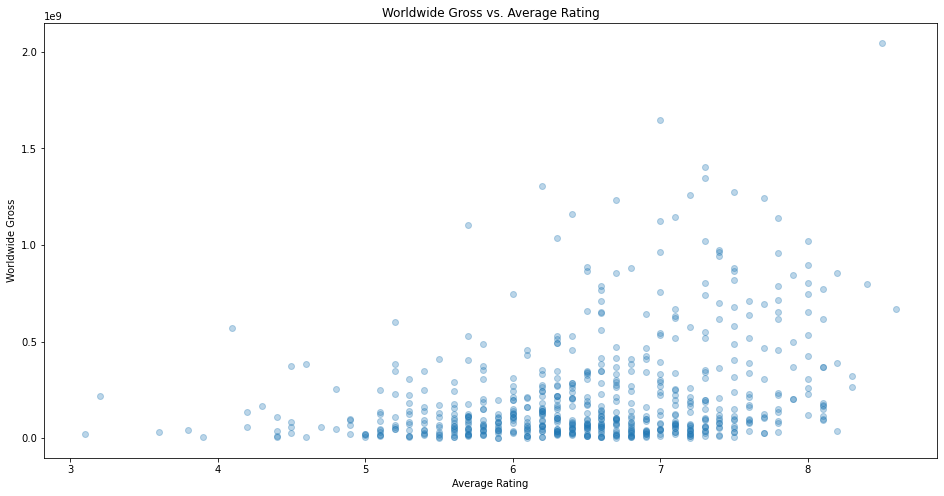

In [159]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.scatter(
    x=Movies_DF_Filtered["averagerating"],
    y=Movies_DF_Filtered["worldwide_gross"],
    alpha=0.3
)

ax.set_ylabel("Worldwide Gross")
ax.set_xlabel("Average Rating")
ax.set_title("Worldwide Gross vs. Average Rating");

In [152]:
Movies_DF_Filtered['ROI'].mean()

2.2888935176054632

Below is code that further filters the movies by specific genres or genre combinations. We also further explore the data by the net income of those genres to determine which has the biggest opportunity. 

In [153]:
#This is where where we created a dataframe for movies that were both action and adventure.
Action_Movies = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Action') == True]
Action_Adv_Movies = Action_Movies[Action_Movies['genres'].str.contains('Adventure') == True]
Action_Adv_Movies

,release_date,movie,production_budget,domestic_gross,worldwide_gross,Net Income,Net_Income_Ratio,ROI,release_year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
1,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-1.337036,-0.572108,2019,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451.0
2,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,0.764364,3.243841,2015,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594.0
3,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,0.853525,5.827114,2018,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
4,2017-11-17,Justice League,300000000,229024295,655945209,355945209,0.542645,1.186484,2017,tt0974015,Justice League,Justice League,2017,120.0,"Action,Adventure,Fantasy",6.5,329135.0
5,2015-11-06,Spectre,300000000,200074175,879620923,579620923,0.658944,1.932070,2015,tt2379713,Spectre,Spectre,2015,148.0,"Action,Adventure,Thriller",6.8,352504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2015-08-21,Hitman: Agent 47,35000000,22467450,82182803,47182803,0.574120,1.348080,2015,tt2679042,Hitman: Agent 47,Hitman: Agent 47,2015,96.0,"Action,Adventure,Crime",5.7,80510.0
582,2018-08-03,The Darkest Minds,34000000,12695691,38361428,4361428,0.113693,0.128277,2018,tt4073790,The Darkest Minds,The Darkest Minds,2018,104.0,"Action,Adventure,Drama",5.7,21340.0
747,2015-09-04,The Transporter Refueled,22000000,16029670,69698495,47698495,0.684355,2.168113,2015,tt2938956,The Transporter Refueled,The Transporter Refueled,2015,96.0,"Action,Adventure,Crime",5.2,36201.0
784,2016-07-27,Nerve,20000000,38583626,70652284,50652284,0.716924,2.532614,2016,tt3531824,Nerve,Nerve,2016,96.0,"Action,Adventure,Crime",6.5,102782.0


In [154]:
#This is where where we created a dataframe for the rest of our genres.
Animated_Movies = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Animation') == True]
Comedy = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Comedy') == True]
Drama = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Drama') == True]
Horror = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Horror') == True]
Horror_thrill_Movies = Action_Movies[Action_Movies['genres'].str.contains('Thriller') == True]
Sci_Fi = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Sci-Fi') == True]




Here we looked at the financial metrics and ratings for the top genres.

In [155]:
 #This is the example for the Action Adventure genre showing how they were created.
Act_Adv_PB = Action_Adv_Movies['production_budget'].mean()
Act_Adv_WG = Action_Adv_Movies['worldwide_gross'].mean()
Act_Adv_NI = Action_Adv_Movies['Net Income'].mean()
Act_Adv_ROI = Action_Adv_Movies['Net Income'].mean() / Action_Adv_Movies['production_budget'].mean()
Act_Adv_AR = Action_Adv_Movies['averagerating'].mean()
Act_Adv_Len = len(Action_Adv_Movies)
print(Act_Adv_PB)
print(Act_Adv_WG)
print(Act_Adv_NI)
print(Act_Adv_ROI)
print(Act_Adv_AR)


137295161.29032257
452317047.3951613
315021886.1048387
2.2944864417959896
6.542276422764228


In [156]:
#Creating the financial and rating metrics for the rest of the top genres.
Animation_PB = Animated_Movies['production_budget'].mean()
Animation_WG = Animated_Movies['worldwide_gross'].mean()
Animation_NI = Animated_Movies['Net Income'].mean()
Animation_ROI = Animated_Movies['Net Income'].mean() / Animated_Movies['production_budget'].mean()
Animation_AR = Animated_Movies['averagerating'].mean()
Animation_Len = len(Animated_Movies)

Comedy_PB = Comedy['production_budget'].mean()
Comedy_WG = Comedy['worldwide_gross'].mean()
Comedy_NI = Comedy['Net Income'].mean()
Comedy_ROI = Comedy['Net Income'].mean() / Comedy['production_budget'].mean()
Comedy_AR = Comedy['averagerating'].mean()
Comedy_Len = len(Comedy)

Drama_PB = Drama['production_budget'].mean()
Drama_WG = Drama['worldwide_gross'].mean()
Drama_NI = Drama['Net Income'].mean()
Drama_ROI = Drama['Net Income'].mean() / Drama['production_budget'].mean()
Drama_AR = Drama['averagerating'].mean()
Drama_Len = len(Drama)

Horror_PB = Horror['production_budget'].mean()
Horror_WG = Horror['worldwide_gross'].mean()
Horror_NI = Horror['Net Income'].mean()
Horror_ROI = Horror['Net Income'].mean() / Horror['production_budget'].mean()
Horror_AR = Horror['averagerating'].mean()
Horror_Len = len(Horror)

Sci_Fi_PB = Sci_Fi['production_budget'].mean()
Sci_Fi_WG = Sci_Fi['worldwide_gross'].mean()
Sci_Fi_NI = Sci_Fi['Net Income'].mean()
Sci_Fi_ROI = Sci_Fi['Net Income'].mean() / Sci_Fi['production_budget'].mean()
Sci_Fi_AR = Sci_Fi['averagerating'].mean()
Sci_Fi_Len = len(Sci_Fi)

In [157]:
#Creating a list of lists of all of our genres and financials metrics to be passed into a DF
data = [['Action/Adv', Act_Adv_PB, Act_Adv_WG, Act_Adv_NI, Act_Adv_ROI, Act_Adv_AR, Act_Adv_Len], 
        ['Animation', Animation_PB, Animation_WG, Animation_NI, Animation_ROI, Animation_AR, Animation_Len],
        ['Comedy', Comedy_PB, Comedy_WG, Comedy_NI, Comedy_ROI, Comedy_AR, Comedy_Len],
        ['Drama',Drama_PB ,Drama_WG ,Drama_NI ,Drama_ROI ,Drama_AR, Drama_Len],
        ['Horror',Horror_PB ,Horror_WG ,Horror_NI ,Horror_ROI ,Horror_AR, Horror_Len],
        ['Sci-Fi',Sci_Fi_PB ,Sci_Fi_WG ,Sci_Fi_NI ,Sci_Fi_ROI ,Sci_Fi_AR, Sci_Fi_Len], 
       ]

One thing to note here is that while comedy movies have a better ROI (2.63x) vs Action Adventure ROI (2.29x), they make significantly less as far as net income (146M vs 315M in USD)

In [158]:
#This DataFrame shows the financial metrics we created
Mean_DF = pd.DataFrame(data, columns=['Movie Genre', 'Production Budget','Worldwide Gross','Net Income','ROI', 'Average Rating', 'Movie Count'])
Mean_DF = Mean_DF.set_index('Movie Genre')
Mean_DF = Mean_DF.astype(float).round(2)

#Converting the floats to $
Mean_DF['Production Budget'] = Mean_DF['Production Budget'].apply(lambda x: "${:.1f}M".format((x/1000000)))
Mean_DF['Worldwide Gross'] = Mean_DF['Worldwide Gross'].apply(lambda x: "${:.1f}M".format((x/1000000)))
Mean_DF['Net Income'] = Mean_DF['Net Income'].apply(lambda x: "${:.1f}M".format((x/1000000)))
Mean_DF

,Production Budget,Worldwide Gross,Net Income,ROI,Average Rating,Movie Count
Movie Genre,,,,,,
Action/Adv,$137.3M,$452.3M,$315.0M,2.29,6.54,124.0
Animation,$95.8M,$405.3M,$309.5M,3.23,6.56,63.0
Comedy,$55.8M,$202.8M,$147.0M,2.63,6.32,213.0
Drama,$41.3M,$114.5M,$73.2M,1.77,6.70,285.0
Horror,$35.7M,$134.0M,$98.3M,2.75,6.06,39.0
Sci-Fi,$119.0M,$436.0M,$317.1M,2.67,6.61,78.0


In [ ]:
# fig, ax = plt.subplots(figsize=(16, 8))

# ax.hist(
#     x=Mean_DF['Movie Genre'],
#     y=Mean_DF['Net Income'],
#     alpha=0.3
# )

# ax.set_ylabel("Net Income")
# ax.set_xlabel("Production Budget")
# ax.set_title("ROI Action Adventure");

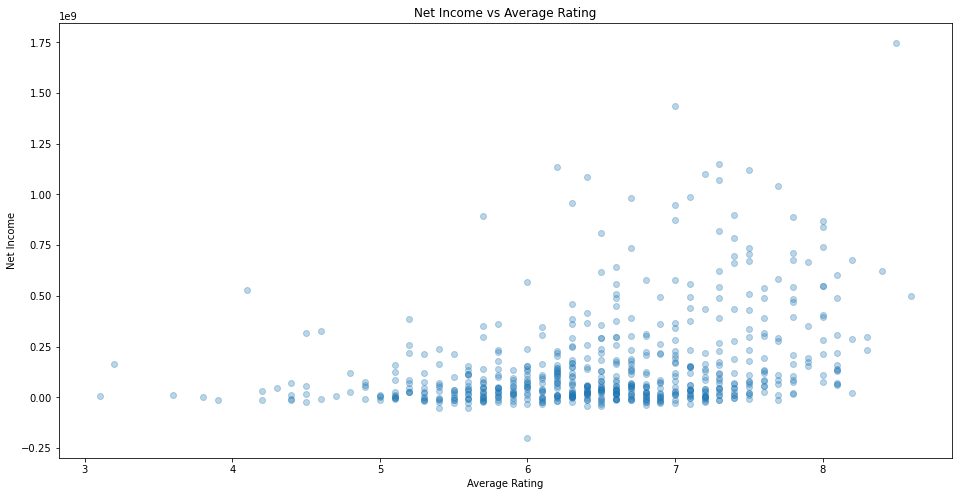

In [181]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.scatter(
    x=Movies_DF_Filtered["averagerating"],
    y=Movies_DF_Filtered['Net Income'],
    alpha=0.3
)

ax.set_ylabel("Net Income")
ax.set_xlabel("Average Rating")
ax.set_title("Net Income vs Average Rating");

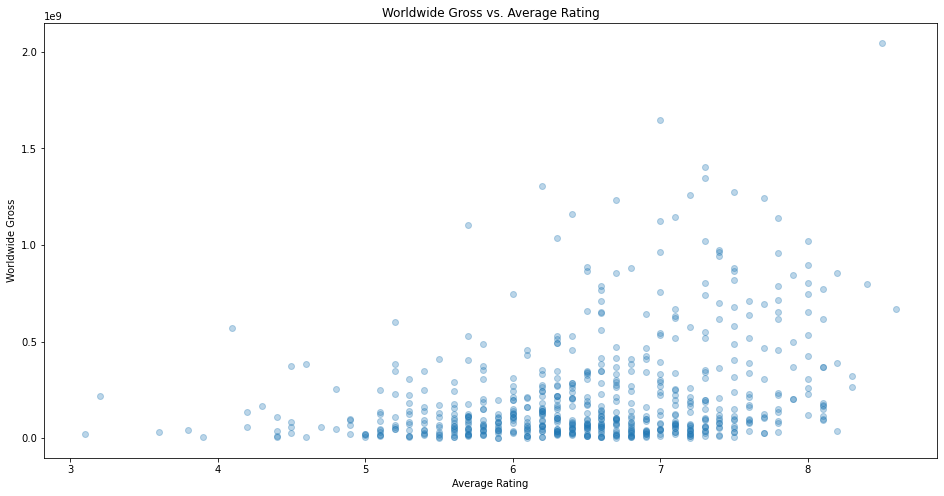

In [99]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.scatter(
    x=Movies_DF_Filtered["averagerating"],
    y=Movies_DF_Filtered["worldwide_gross"],
    alpha=0.3
)

ax.set_ylabel("Worldwide Gross")
ax.set_xlabel("Average Rating")
ax.set_title("Worldwide Gross vs. Average Rating");

In [178]:
#Recreating Mean_DF where the numbers are ints so we can use for bar graphs
Mean_DF_Bar = pd.DataFrame(data, columns=['Movie Genre', 'Production Budget','Worldwide Gross','Net Income','ROI', 'Average Rating', 'Movie Count'])
Mean_DF_Bar = Mean_DF_Bar.set_index('Movie Genre')
Mean_DF_Bar = Mean_DF_Bar.astype(int).round(2)

Mean_DF_Bar

,Production Budget,Worldwide Gross,Net Income,ROI,Average Rating,Movie Count
Movie Genre,,,,,,
Action/Adv,137295161,452317047,315021886,2,6,124
Animation,95833333,405311216,309477883,3,6,63
Comedy,55802347,202790374,146988027,2,6,213
Drama,41272631,114451215,73178584,1,6,285
Horror,35728205,134015623,98287418,2,6,39
Sci-Fi,118964102,436048608,317084505,2,6,78


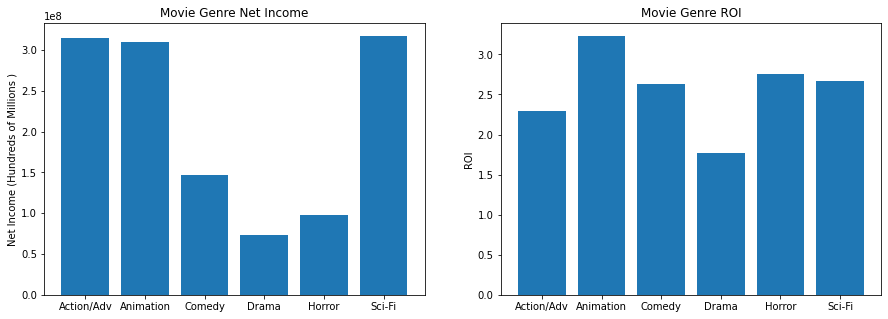

In [180]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

ax1.bar(
    x = Mean_DF_Bar.index,
    height = Mean_DF_Bar['Net Income']
)

ax2.bar(
    x = Mean_DF.index,
    height = Mean_DF['ROI']
)

ax1.set_title("Movie Genre Net Income")
ax2.set_title("Movie Genre ROI")
ax1.set_ylabel("Net Income (Hundreds of Millions )")
ax2.set_ylabel("ROI");

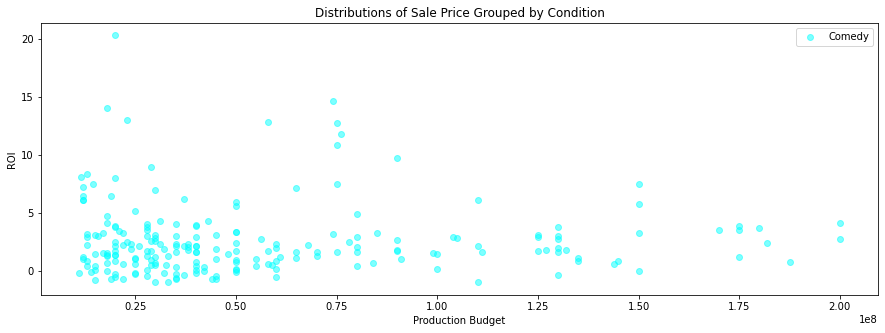

In [166]:
#Histogram for production budget vs Net Income for top genres
# Set up plot
fig, ax = plt.subplots(figsize=(15,5))


# # Plot three scatter, with reduced opacity (alpha) so we
# # can see them overlapping
ax.scatter(
    x=Comedy['production_budget'],
    y=Comedy['ROI'],
    alpha=0.5,
    color="cyan",
    label="Comedy"
)
# ax.hist(
#     x=Comedy_hist['production_budget'],
#     label="average condition",
#     bins=bins,
#     color="gray",
#     alpha=0.3
# )
# ax.hist(
#     x=below_average_condition["SalePrice"],
#     label="below average condition",
#     bins=bins,
#     color="yellow",
#     alpha=0.5
# )

# Customize labels
ax.set_title("Distributions of Sale Price Grouped by Condition")
ax.set_xlabel("Production Budget")
ax.set_ylabel("ROI")
ax.legend();

In [90]:
Movies_DF_Filtered['release_month'] = pd.DatetimeIndex(Movies_DF_Filtered['release_date']).month
Movies_DF_Month = Movies_DF_Filtered.sort_values(by='release_month')
Movies_DF_Month

<ipython-input-90-275e2afcb6b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Movies_DF_Filtered['release_month'] = pd.DatetimeIndex(Movies_DF_Filtered['release_date']).month


,release_date,movie,production_budget,domestic_gross,worldwide_gross,Net Income,Net_Income_Ratio,ROI,release_year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,release_month
895,2013-01-18,Mama,15000000,71628180,148095566,133095566,0.898714,8.873038,2013,tt2023587,Mama,Mama,2013,100.0,"Horror,Thriller",6.2,158487.0,1
345,2013-01-11,Gangster Squad,60000000,46000903,104100903,44100903,0.423636,0.735015,2013,tt1321870,Gangster Squad,Gangster Squad,2013,113.0,"Action,Crime,Drama",6.7,195560.0,1
637,2018-01-12,Proud Mary,30000000,20868638,21709539,-8290461,-0.381881,-0.276349,2018,tt6421110,Proud Mary,Proud Mary,2018,89.0,"Action,Crime,Drama",4.9,6805.0,1
343,2014-01-17,Jack Ryan: Shadow Recruit,60000000,50577412,131377412,71377412,0.543300,1.189624,2014,tt1205537,Jack Ryan: Shadow Recruit,Jack Ryan: Shadow Recruit,2014,105.0,"Action,Drama,Thriller",6.2,114913.0,1
977,2015-01-30,Project Almanac,12000000,22348241,32909437,20909437,0.635363,1.742453,2015,tt2436386,Project Almanac,Project Almanac,2015,106.0,"Drama,Mystery,Sci-Fi",6.4,71500.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,2018-12-25,Vice,60000000,47836282,70883171,10883171,0.153537,0.181386,2018,tt6266538,Vice,Vice,2018,132.0,"Biography,Comedy,Drama",7.2,72855.0,12
359,2014-12-25,American Sniper,58000000,350126372,547326372,489326372,0.894030,8.436662,2014,tt2179136,American Sniper,American Sniper,2014,133.0,"Action,Biography,Drama",7.3,401915.0,12
366,2014-12-25,Into the Woods,56200000,128002372,213116401,156916401,0.736294,2.792107,2014,tt2180411,Into the Woods,Into the Woods,2014,125.0,"Adventure,Comedy,Drama",6.0,123577.0,12
829,2017-12-01,The Shape of Water,19500000,63859435,195790794,176290794,0.900404,9.040554,2017,tt5580390,The Shape of Water,The Shape of Water,2017,123.0,"Adventure,Drama,Fantasy",7.3,308112.0,12


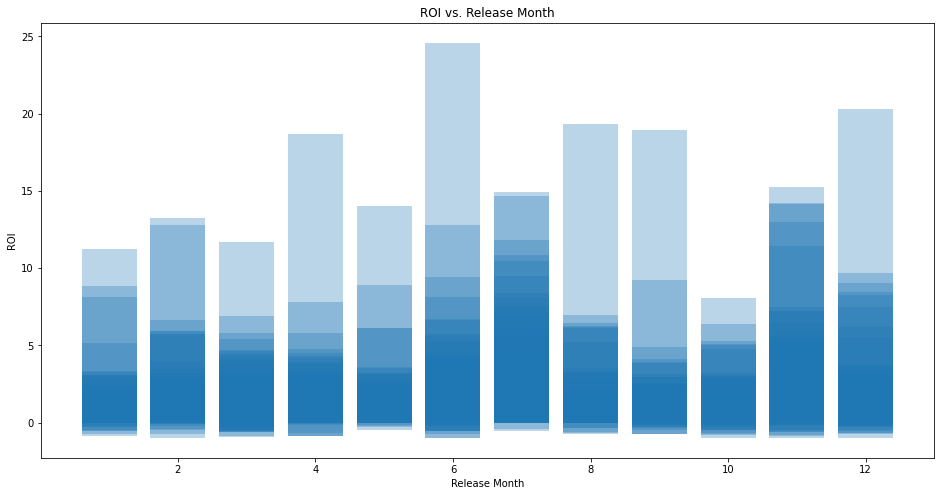

In [91]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(
    height=Movies_DF_Filtered['ROI'],
    x=Movies_DF_Filtered['release_month'],
    alpha=0.3
)

# ax.set_yticks(np.arange(0, 4,0.4))

ax.set_ylabel("ROI")
ax.set_xlabel("Release Month")
ax.set_title("ROI vs. Release Month");

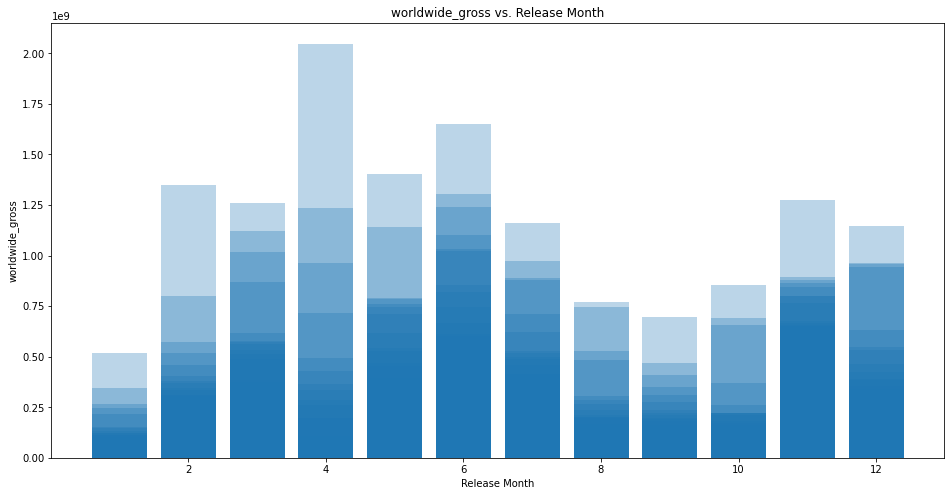

In [92]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(
    height=Movies_DF_Filtered['worldwide_gross'],
    x=Movies_DF_Filtered['release_month'],
    alpha=0.3
)

# ax.set_yticks(np.arange(0, 4,0.4))

ax.set_ylabel("worldwide_gross")
ax.set_xlabel("Release Month")
ax.set_title("worldwide_gross vs. Release Month");

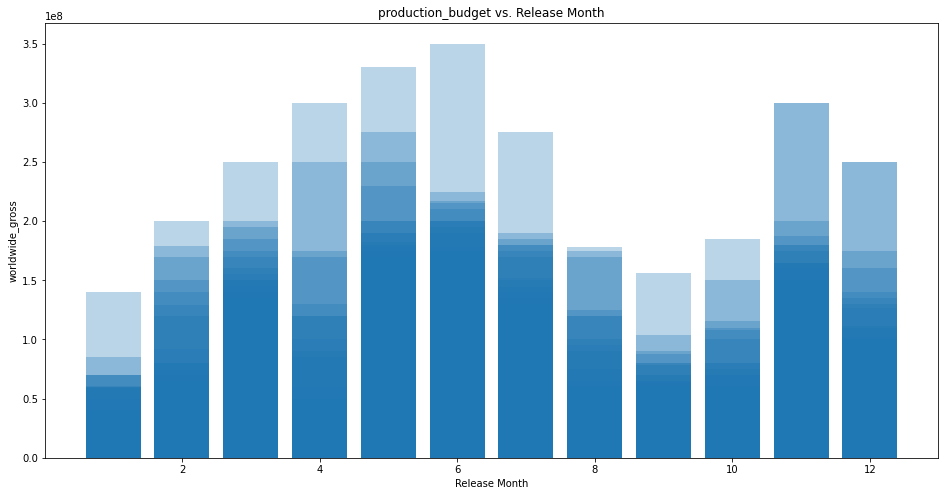

In [93]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(
    height=Movies_DF_Filtered['production_budget'],
    x=Movies_DF_Filtered['release_month'],
    alpha=0.3
)

# ax.set_yticks(np.arange(0, 4,0.4))

ax.set_ylabel("worldwide_gross")
ax.set_xlabel("Release Month")
ax.set_title("production_budget vs. Release Month");